# Reconocimiento de Patrones
[Curso de Reconocimiento de Patrones](https://https://domingomery.ing.puc.cl/teaching/patrones/)

Departamento de Ciencia de la Computación

Universidad Catolica de Chile

(c) Domingo Mery, http://domingomery.ing.uc.cl



# Ejemplo: Reconocimiento de Texturas

En este ejemplo se muestra cómo usar Haralick y Gabor en el reconocimiento de texturas.
Referencias:

* [Paper sobre Haralick](https://www.dropbox.com/s/oijgbbowrhw0iq7/Haralick_Textures.pdf?dl=0)

* [Paper sobre Gabor](https://www.dropbox.com/s/8cr75ivze5m19by/Manjunath_GaborFeatures1996.pdf?dl=0)



En este ejemplo se realiza el reconocimiento en una base de datos muy conocida(*) que contiene 111 texturas y cada una de ellas con 9 fotos. Aquí algunos ejemplos.


(*) [Brodatz](https://multibandtexture.recherche.usherbrooke.ca/colored%20_brodatz.html)



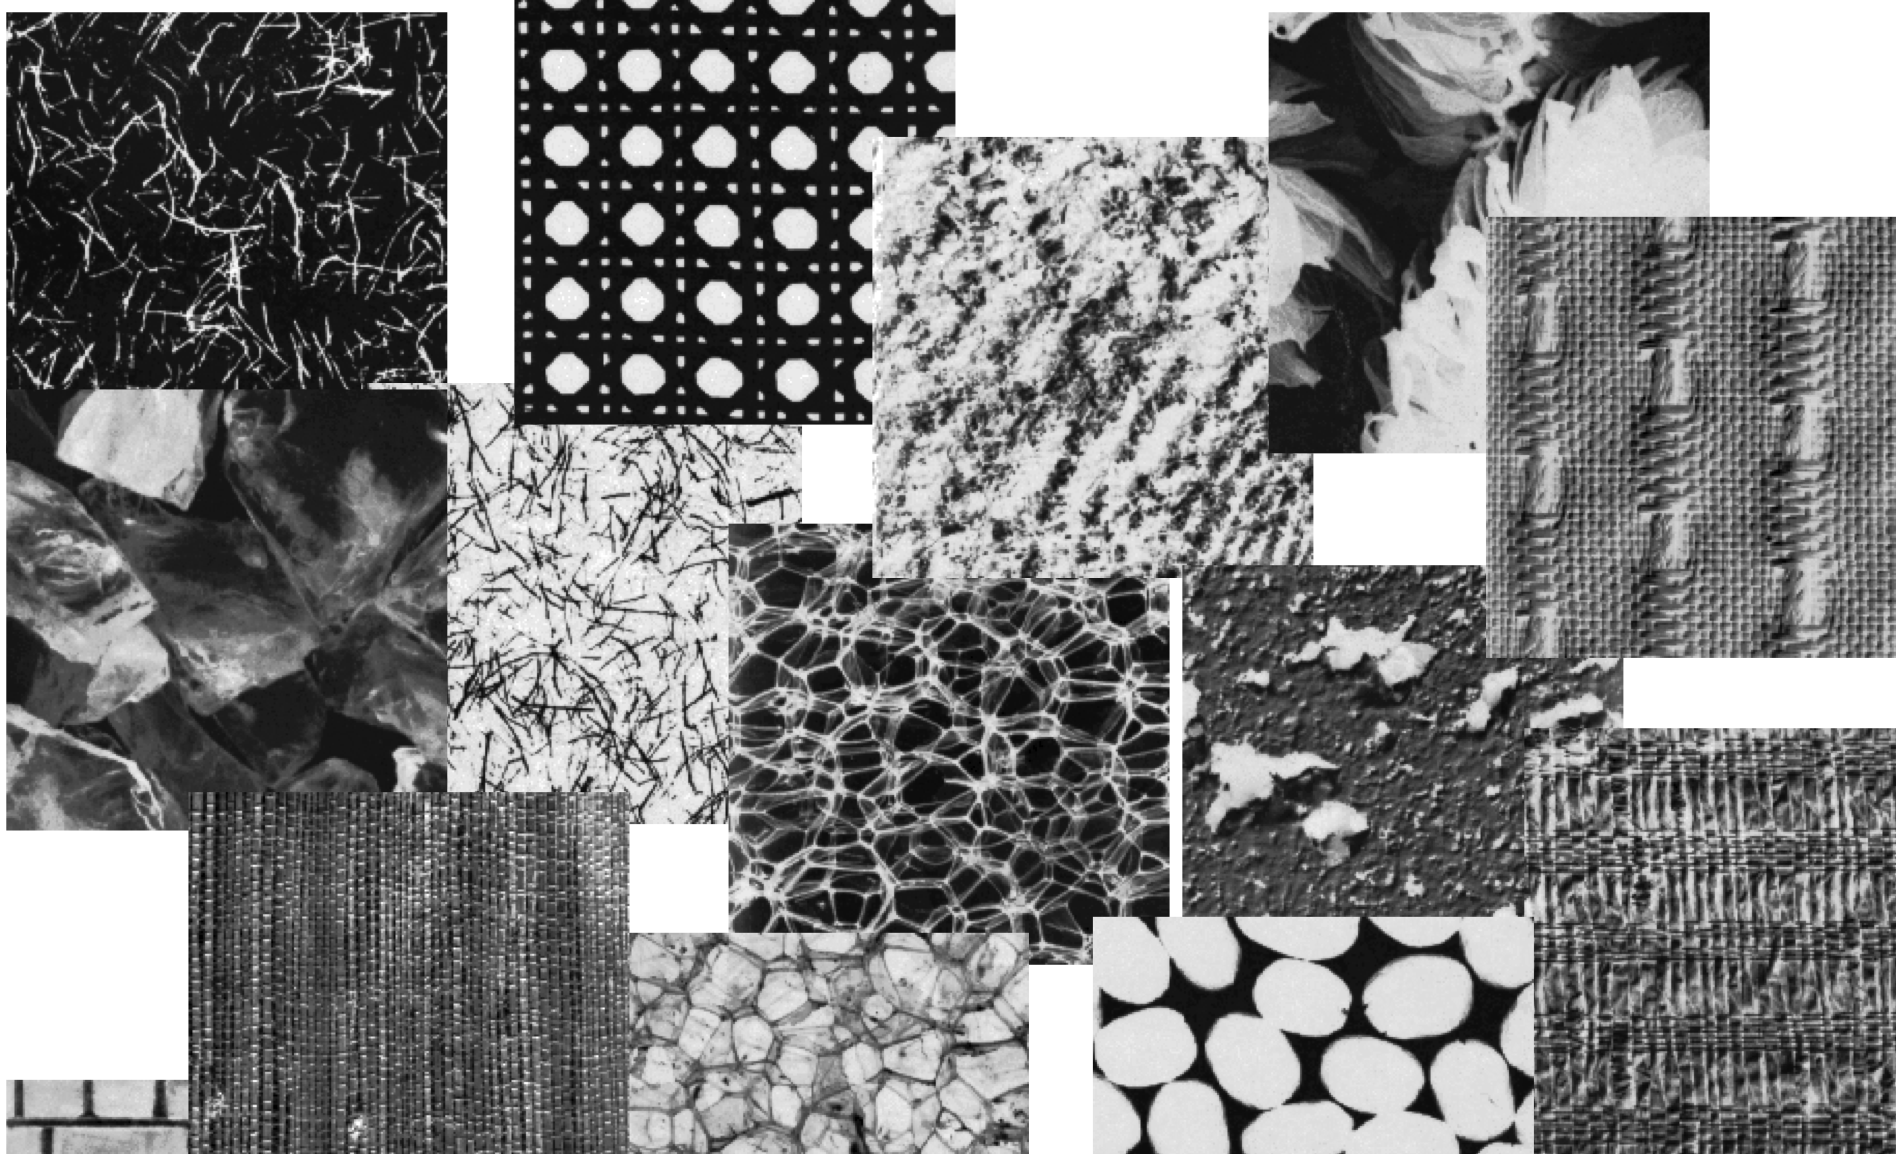

# Setup inicial

Liberías necesarias para que funcione el algoritmo.

## Instalación de PyBalu

[PyBalu](https://github.com/mbucchi/pybalu) es una librería creada para extraer características. 

In [ ]:
# Instalación de Balu
!pip install scipy==1.2
!pip3 install pybalu==0.2.5
print('PyBalu library installed.')


     |████████████████████████████████| 26.6MB 19.4MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
     |████████████████████████████████| 1.4MB 15.1MB/s 
     |████████████████████████████████| 3.3MB 32.3MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: imageio 2.4.1
    Uninstalling imageio-2.4.1:
      Successfully uninstalled imageio-2.4.1
PyBalu library installed.


## Setup de librerías

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from   sklearn.metrics import confusion_matrix, accuracy_score
from   sklearn.neighbors import KNeighborsClassifier
from   seaborn import heatmap
from   google.colab.patches import cv2_imshow 
from   tqdm.auto import tqdm
from   pybalu.feature_extraction import lbp_features, haralick_features, gabor_features
from   pybalu.feature_transformation import normalize


# Carga de base de datos

La base de datos consiste en 111 clases y 9 imágenes por clase. Se almacenan en la carpeta ORL con el formato face_xxx_nnn.png, donde xxx es el ID de la textura (001, 002, ... 111) y nnn es el número de la foto de la textura (001, 002, ... 009).

In [ ]:
# Carga de base de datos
!wget https://www.dropbox.com/s/pami9abpbfoyfsm/textures.zip
!unzip textures

# Funciones necesarias

In [ ]:
def num2fixstr(x,d):
  # example num2fixstr(2,5) returns '00002'
  # example num2fixstr(19,3) returns '019'
  st = '%0*d' % (d,x)
  return st

def ImageLoad(prefix,num_char,num_img,echo='off'):
  st   = prefix + num2fixstr(num_char,3) + '_' + num2fixstr(num_img,3) + '.png'
  if echo == 'on':
    print('loading image '+st+'...')
  img    = plt.imread(st)
  return img

# Extracción de características

In [ ]:
# ADVERTENCIA: si K es grande y se extraen características de Gabor, este proceso
# puede durar unos 30 minutos!

K     = 111   # número de clases
N     = 9     # número de imágenes por clase
Mlbp  = 59
MHar1 = 28
MHar3 = 28
MHar5 = 28
Mgab  = 67

Xlbp  = np.zeros((K*N,Mlbp))    # K x N muestras (filas), y Mlbp  características (columnas)
XHar1 = np.zeros((K*N,MHar1))   # K x N muestras (filas), y Mhar1 características (columnas)
XHar3 = np.zeros((K*N,MHar3))   # K x N muestras (filas), y Mhar3 características (columnas)
XHar5 = np.zeros((K*N,MHar5))   # K x N muestras (filas), y Mhar5 características (columnas)
Xgab  = np.zeros((K*N,Mgab))    # K x N muestras (filas), y Mgab  características (columnas)

y     = np.zeros((K*N),'int')           # ground truth (clasificacion ideal)

t = 0
print('Cargando imagenes y extrayendo características...')
for j in tqdm(range(K)):            # para cada clase
  for i in range(N):                # para cada imagen de la clase
    # Lectura de la imagen
    img    = 255*ImageLoad('textures/D',j+1,i+1,echo='off')

    # Extracción de características
    Xlbp[t,:]  = lbp_features(img, hdiv=1, vdiv=1, mapping='nri_uniform')
    XHar1[t,:] = haralick_features(img, distance=1)
    XHar3[t,:] = haralick_features(img, distance=3)
    XHar5[t,:] = haralick_features(img, distance=5)
    Xgab[t,:]  = gabor_features(img, rotations=8, dilations=8)
    y[t] = j
    t = t+1


Cargando imagenes y extrayendo características...


# Selección (Manual) de Características


In [ ]:
# Escoger características a usar
# ------------------------------
#

#X = np.concatenate((XHar1, XHar3, XHar5, Xgab, Xlbp), axis=1)
#X = np.concatenate((XHar5, XHar3), axis=1)
X = Xlbp
#X = Xgab
#X = XHar1
print('X tiene '+str(X.shape[0])+' filas, y '+str(X.shape[1])+' columnas.')

X tiene 999 filas, y 59 columnas.


# Separación Training/Testing

Antes de diseñar el clasificador, debemos hacer la separación de los datos en subset de Training y substets de Testing. En este ejemplo usamos una imagen de cada textura para el testing (primera imagen) y el resto para el training:

* Training: las primeras 8 imágenes de cada textura

* Testing: la última imagen de cada textura

In [ ]:
# Separación entre training y testing
# Se escoge la primera foto de cada textura para testing, el resto para training

M = X.shape[1]

Xtrain = np.zeros((K*(N-1),M))  # 8 fotos por textura para training
ytrain = np.zeros((K*(N-1)),'int')
Xtest  = np.zeros((K,M))        # 1 foto por textura para testing
ytest  = np.zeros((K),'int')

itest  = 8                      # imagen escogida para testing, puede ser 0,1,..8

ktrain = 0                      # contador para Xtrain
ktest  = 0                      # contador para Xtest
for i in range(K*N):
  if np.mod(i,N)==itest:
    Xtest[ktest,:] = X[i,:]
    ytest[ktest]   = y[i]
    ktest = ktest+1
  else:
    Xtrain[ktrain,:] = X[i,:]
    ytrain[ktrain]   = y[i]
    ktrain = ktrain+1

print('Separación Training/Testing realizada.')


print('Xtrain tiene '+str(Xtrain.shape[0])+' filas, y '+str(Xtrain.shape[1])+' columnas.')
print('Xtest  tiene '+str(Xtest.shape[0])+' filas, y '+str(Xtest.shape[1])+' columnas.')

Xtrain, a, b = normalize(Xtrain)
Xtest = Xtest * a + b

# print('Normalización realizada.')




Separación Training/Testing realizada.
Xtrain tiene 888 filas, y 59 columnas.
Xtest  tiene 111 filas, y 59 columnas.


# Clasificación usando KNN

En este ejemplo se usa la implementación de sklearn para KNN

In [ ]:
numero_vecinos = 5
knn = KNeighborsClassifier(n_neighbors=numero_vecinos)
knn.fit(Xtrain, ytrain)
KNeighborsClassifier(...)
ypred = knn.predict(Xtest)
print('Clasificación usando KNN-'+str(numero_vecinos)+ ' en '+str(K)+' imágenes de testing realizada.')

Clasificación usando KNN-5 en 111 imágenes de testing realizada.


# Evaluación de desempeño

In [ ]:
acc = accuracy_score(ytest,ypred)
print('Testing Accuracy = '+str(acc*100)+'%')

Testing Accuracy = 90.990990990991%


Matriz de Confusión:


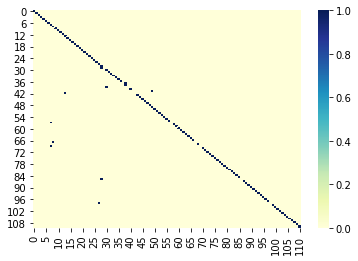

In [ ]:
C = confusion_matrix(ytest,ypred)
print('Matriz de Confusión:')
heatmap(C, cmap="YlGnBu")

# Visualización de imágenes mal clasificadas

Error de Clasificación: se confundió texture 7 (foto de testing)...


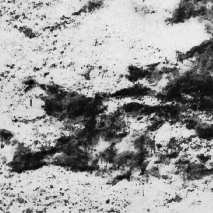

... ya que fue clasificada como textura 111 (fotos de training):


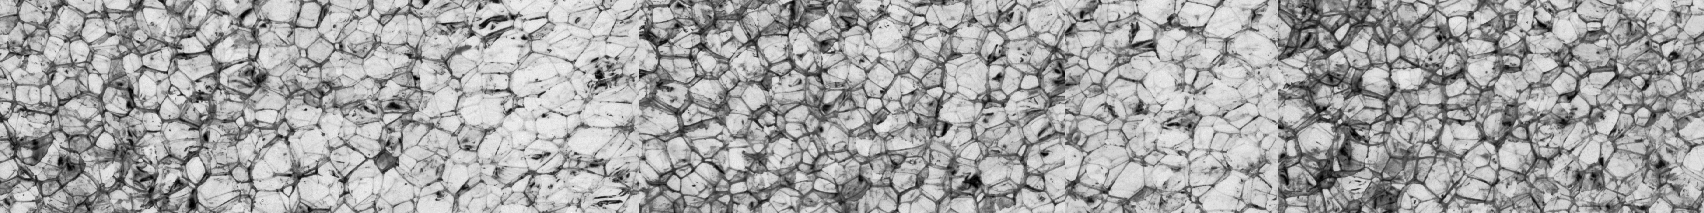

---------------------------------------------
Error de Clasificación: se confundió texture 42 (foto de testing)...


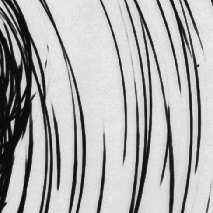

... ya que fue clasificada como textura 14 (fotos de training):


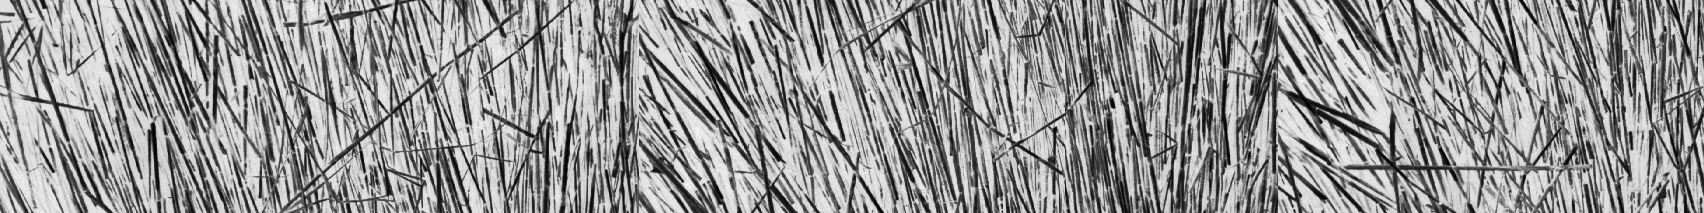

---------------------------------------------
Error de Clasificación: se confundió texture 57 (foto de testing)...


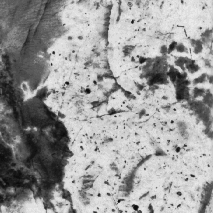

... ya que fue clasificada como textura 7 (fotos de training):


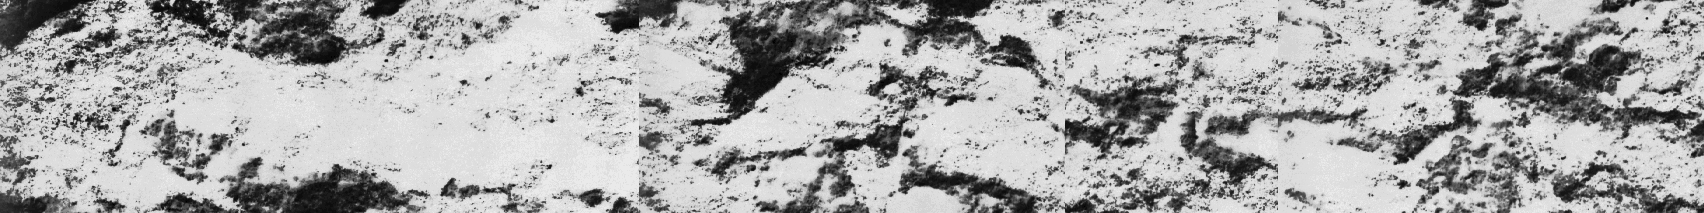

---------------------------------------------
Error de Clasificación: se confundió texture 60 (foto de testing)...


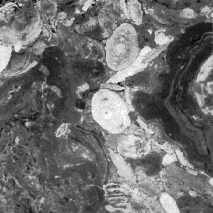

... ya que fue clasificada como textura 26 (fotos de training):


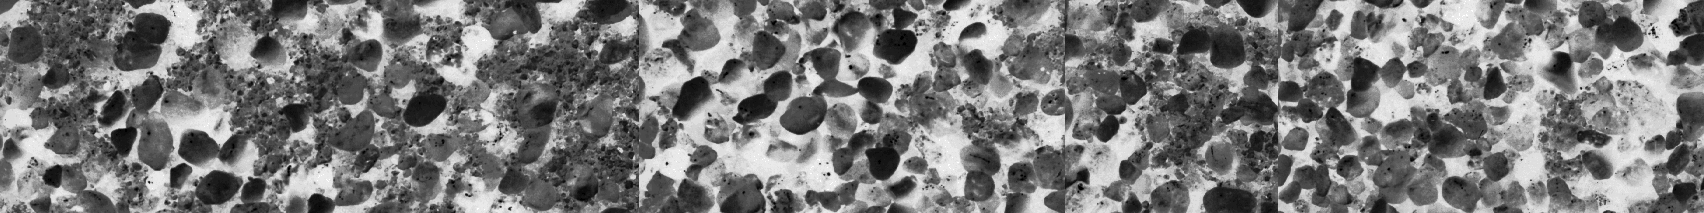

---------------------------------------------
Error de Clasificación: se confundió texture 61 (foto de testing)...


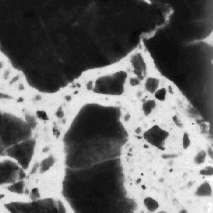

... ya que fue clasificada como textura 29 (fotos de training):


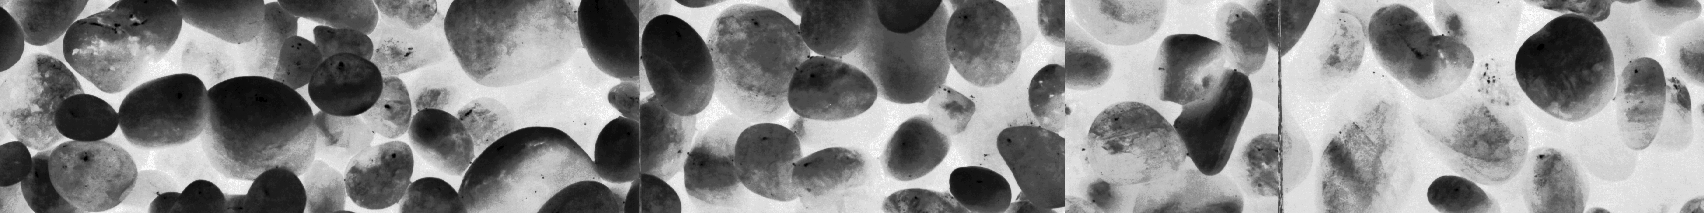

---------------------------------------------
Error de Clasificación: se confundió texture 72 (foto de testing)...


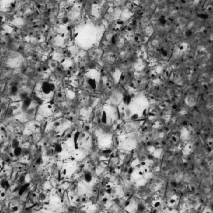

... ya que fue clasificada como textura 27 (fotos de training):


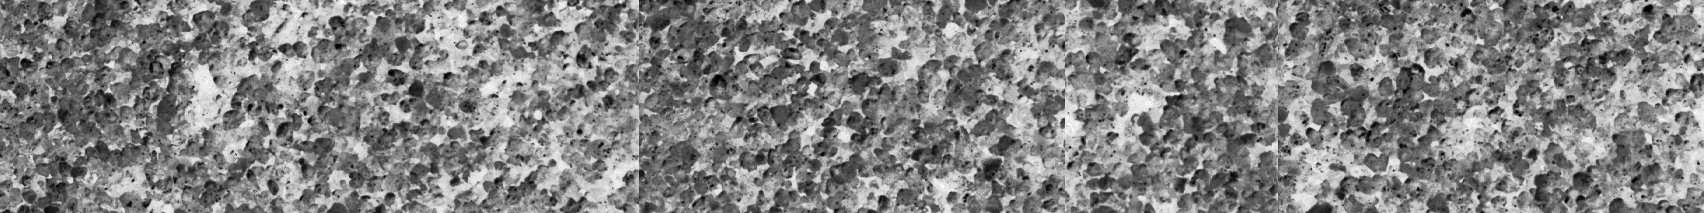

---------------------------------------------
Error de Clasificación: se confundió texture 87 (foto de testing)...


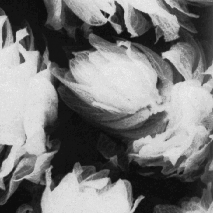

... ya que fue clasificada como textura 30 (fotos de training):


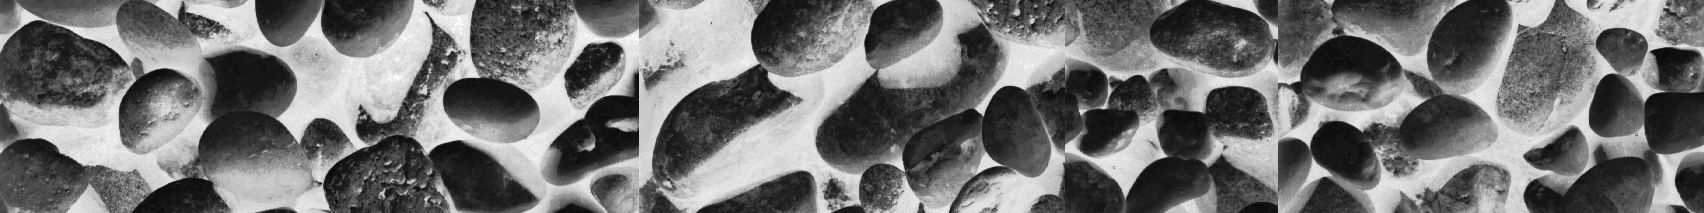

---------------------------------------------
Error de Clasificación: se confundió texture 99 (foto de testing)...


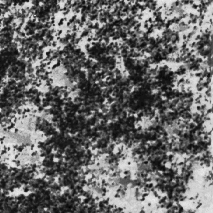

... ya que fue clasificada como textura 110 (fotos de training):


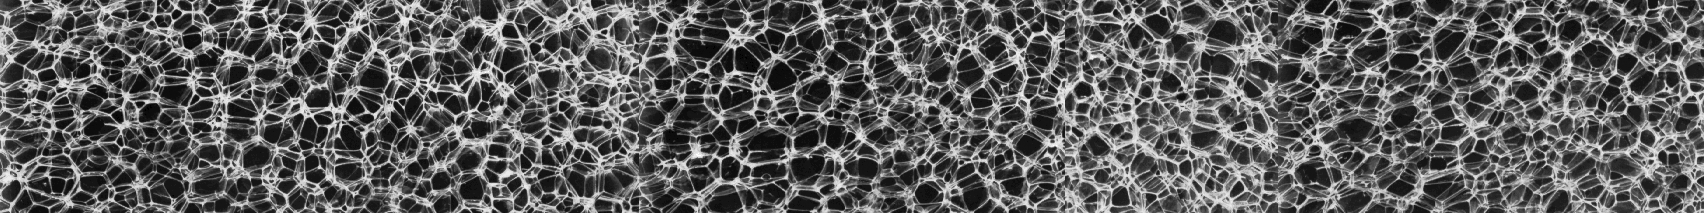

---------------------------------------------
Error de Clasificación: se confundió texture 107 (foto de testing)...


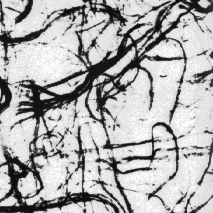

... ya que fue clasificada como textura 96 (fotos de training):


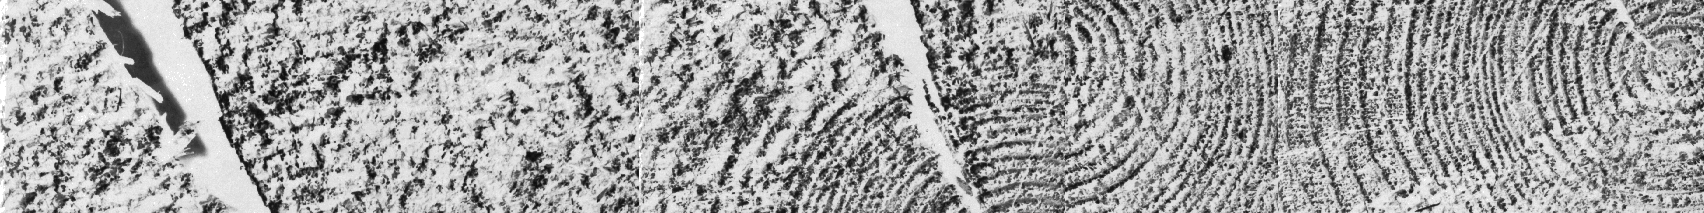

---------------------------------------------


In [ ]:
for i in range(K):
  for j in range(K):
    if i!=j and C[i,j]>0:
      # Imagen de testing
      I     = ImageLoad('textures/D',i+1,itest+1,echo='off')      
      # Imágenes de training
      ini = 1
      for k in range(N):
        if k!=itest:
          Jk  = ImageLoad('textures/D',j+1,k+1,echo='off')
          if ini==1:
            ini = 0
            J = Jk
          else:
            J = cv2.hconcat([J,Jk])
      print('Error de Clasificación: se confundió texture '+str(i+1)+' (foto de testing)...')
      cv2_imshow(I*255)
      print('... ya que fue clasificada como textura '+str(j+1)+' (fotos de training):')
      #implot = plt.imshow(IJ,cmap='gray')
      cv2_imshow(J*255)
      print('---------------------------------------------')
      
      